In [3]:
import Pkg; Pkg.activate(".")
Pkg.instantiate()
using BLUEs, LinearAlgebra, Random, 
      Distributions, 
      ToeplitzMatrices
using Plots; pythonplot()

  Activating project at `~/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/Documents/GitHub/BLUEs.jl/notebooks`


Plots.PythonPlotBackend()

In [39]:
function piecewise_linear_regression_matrix(xgrid, ygrid)
    nx = length(xgrid)
    ny = length(ygrid)
    
    E = zeros(ny, nx)
    
    for (i, yg) in enumerate(ygrid)
        δxlo, ixlo = findmin(x -> (x > 0) ? abs(x) : Inf, yg .- xgrid) #find closest left point, depends on oriengation
        δxhigh, ixhigh = findmin(x -> (x ≤ 0) ? abs(x) : Inf,  yg .- xgrid) #find closest right point, depends on oriengation
        Δx = xgrid[ixhigh] - xgrid[ixlo]
        
        δxpt = yg - xgrid[ixlo]
        if ixhigh != ixlo
            a = δxpt / Δx
        else 
            println("E has NaNs, Changing all NaNs to zero")
            a = 0
        end
        E[i, ixlo] = (1-a)
        E[i, ixhigh] = a
    end
    
    if any(isnan.(E))
        E[isnan.(E)] .= 0.0
    end
    return E
end

function gauss_markov_mapping(yobs, ygrid, xgrid; Lt = 5, σx = 3, σn = 0.5, 
                              x0 = nothing)
    
    nx = length(xgrid)
    ny = length(ygrid)
    
    H = piecewise_linear_regression_matrix(xgrid, ygrid)

    DX = zeros(nx, nx)
    [DX[i, j] = (jx - ix) for (i, ix) in enumerate(xgrid) for (j, jx) in enumerate(xgrid)]
    Cxx = σx .* exp.(-(DX ./ Lt).^2)
    Cnn = σn * diagm(ones(ny))
    
    #uncertainty
    P = Cxx - Cxx * H' * inv(H * Cxx * H' + Cnn) * H * Cxx
    
    if isnothing(x0)
        x̃ = Cxx * H' * inv(H*Cxx*H' .+ Cnn) * yobs
        return x̃, sqrt.(diag(P))
    else
        x̃ = (Cxx * H' * inv(H*Cxx*H' .+ Cnn) * (yobs .- (H*x0)[:]))
        x̃ .+= x0
        return x̃, sqrt.(diag(P))
    end
end


function gauss_markov_mapping_BLUES(yobs, ygrid, xgrid; Lt = 5, σx = 3, σn = 0.5, x0 = nothing)
    
    nx = length(xgrid)
    ny = length(ygrid)
    
    H = piecewise_linear_regression_matrix(xgrid, ygrid)

    DX = zeros(nx, nx)
    [DX[i, j] = (jx - ix) for (i, ix) in enumerate(xgrid) for (j, jx) in enumerate(xgrid)]
    Cxx = σx .* exp.(-(DX ./ Lt).^2)
    Cnn = σn * diagm(ones(ny))

    if isnothing(x0)
        y = Estimate(yobs,Cnn)
    	x0e = Estimate(xgrid .* 0.0, Cxx)
        x̃ = combine(x0e, y, H)
        return (x̃.v, x̃.σ)
    else
        y = Estimate(yobs,Cnn)
    	x0e = Estimate(x0, Cxx)
        x̃ = combine(x0e, y, H)
        return (x̃.v, x̃.σ)
    end
end

plot_uncertainty(xgrid, x̃, σx̃; color = "red", alpha = 0.2) = plot(xgrid, x̃ - 2σx̃, fillrange = x̃  + 2σx̃, color = color, alpha = 0.2, label = nothing) 

plot_uncertainty!(xgrid, x̃, σx̃; color = "red", alpha = 0.2) =  plot!(xgrid, x̃ - 2σx̃, fillrange = x̃  + 2σx̃, color = color, alpha = 0.2, label = nothing) 


plot_uncertainty! (generic function with 1 method)

# A Sine Wave

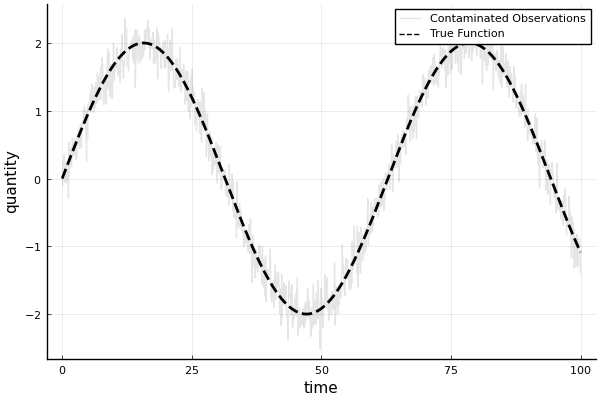

In [68]:
a, b = (0, 100)
nx = 1000
xgrid = collect(LinRange(a, b, nx))
myfunc(x) = sin(x/10) * 2
σn = 0.2
xobs = myfunc.(xgrid) .+ rand(Normal(0, σn), nx)

#get random observations
ny =Int(round(0.15 * nx))
ygrid = rand(Uniform(a, b), ny)

plot(xgrid, xobs, label = "Contaminated Observations", 
        alpha = 0.1, color = "black", 
        xlabel = "time", ylabel = "quantity")
plot!(xgrid, myfunc.(xgrid), color = "black", label = "True Function", 
      alpha = 1, linestyle = :dash, lw = 2)

## Sparse Observations

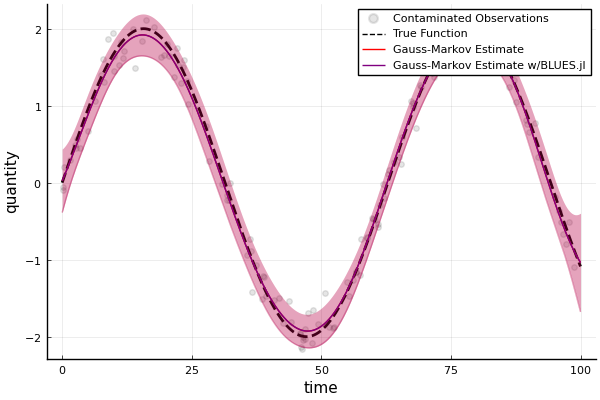

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [69]:
H = piecewise_linear_regression_matrix(xgrid, ygrid)
yobs = H * xobs

Lt = 15
σx = 3

x̃, σx̃ = gauss_markov_mapping(yobs, ygrid, xgrid; Lt = Lt, σx = σx, σn = σn)
x̃b, σx̃b = gauss_markov_mapping_BLUES(yobs, ygrid, xgrid; Lt = Lt, σx = σx, σn = σn)

scatter(ygrid, yobs, label = "Contaminated Observations", 
        alpha = 0.1, markercolor = "black", 
        xlabel = "time", ylabel = "quantity")
plot!(xgrid, myfunc.(xgrid), color = "black", label = "True Function", 
      alpha = 1, linestyle = :dash, lw = 2)


plot!(xgrid, x̃, color = "red", label = "Gauss-Markov Estimate")
plot_uncertainty!(xgrid, x̃, σx̃; color = "red", alpha = 0.3)

plot!(xgrid, x̃b, color = "purple", label = "Gauss-Markov Estimate w/BLUES.jl")
plot_uncertainty!(xgrid, x̃b, σx̃b; color = "purple", alpha = 0.3)

## Missing Observations

E has NaNs, Changing all NaNs to zero
E has NaNs, Changing all NaNs to zero
E has NaNs, Changing all NaNs to zero


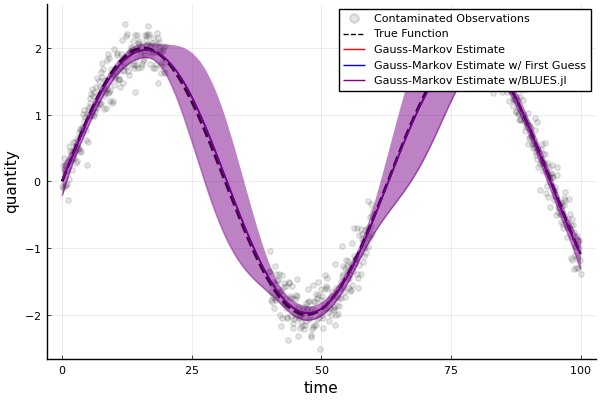

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [70]:
Lt = 15
σx = 3
yobs = vcat(xobs[1:200], xobs[400:600], xobs[800:end])
ygrid = vcat(xgrid[1:200], xgrid[400:600], xgrid[800:end])

x0 = ones(nx) .* mean(yobs)

x̃, σx̃ = gauss_markov_mapping(yobs, ygrid, xgrid; Lt = Lt, σx = σx, σn = σn)
x̃_fg, σx̃_fg = gauss_markov_mapping(yobs, ygrid, xgrid; Lt = Lt, σx = σx, σn = σn, x0 = x0)
x̃b, σx̃b = gauss_markov_mapping_BLUES(yobs, ygrid, xgrid; Lt = Lt, σx = σx, σn = σn)

scatter(ygrid, yobs, label = "Contaminated Observations", 
        alpha = 0.1, markercolor = "black", 
        xlabel = "time", ylabel = "quantity")
plot!(xgrid, myfunc.(xgrid), color = "black", label = "True Function", 
      alpha = 1, linestyle = :dash, lw = 2)

plot!(xgrid, x̃, color = "red", label = "Gauss-Markov Estimate")
plot_uncertainty!(xgrid, x̃, σx̃; color = "red", alpha = 0.3)

plot!(xgrid, x̃_fg, color = "blue", label = "Gauss-Markov Estimate w/ First Guess")
plot_uncertainty!(xgrid, x̃_fg, σx̃_fg; color = "blue", alpha = 0.3)

plot!(xgrid, x̃b, color = "purple", label = "Gauss-Markov Estimate w/BLUES.jl")
plot_uncertainty!(xgrid, x̃b, σx̃b; color = "purple", alpha = 0.3)

# A Sine Wave Plus Linear Trend and Mean 

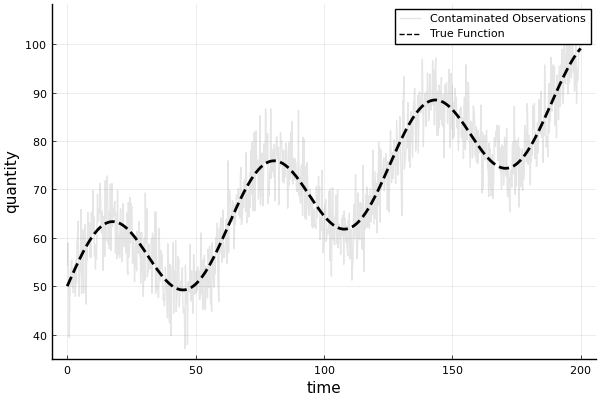

In [72]:
a, b = (0, 200)
nx = 1000
xgrid = collect(LinRange(a, b, nx))
μ = 50
β = 0.2
σn = 4
α = 4
σn = 5

myfunc(x) = (10 * sin(x/10)) .+ μ .+ (β .* x)
xobs = myfunc.(xgrid) .+ rand(Normal(0, σn), nx)

#get random observations
ny =Int(round(0.2 * nx))
ygrid = rand(Uniform(a, b), ny)

plot(xgrid, xobs, label = "Contaminated Observations", 
        alpha = 0.1, color = "black", 
        xlabel = "time", ylabel = "quantity")
plot!(xgrid, myfunc.(xgrid), color = "black", label = "True Function", 
      alpha = 1, linestyle = :dash, lw = 2)



## Sparse Observations

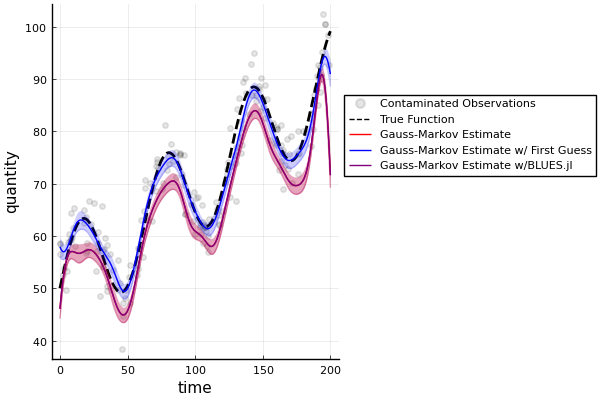

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [73]:
H = piecewise_linear_regression_matrix(xgrid, ygrid)
yobs = H * xobs

Lt = 10
σx = 5

x0 = ones(nx) .* mean(yobs)

x̃, σx̃ = gauss_markov_mapping(yobs, ygrid, xgrid; Lt = Lt, σx = σx, σn = σn)
x̃_fg, σx̃_fg = gauss_markov_mapping(yobs, ygrid, xgrid; Lt = Lt, σx = σx, σn = σn, x0 = x0)
x̃b, σx̃b = gauss_markov_mapping_BLUES(yobs, ygrid, xgrid; Lt = Lt, σx = σx, σn = σn)

scatter(ygrid, yobs, label = "Contaminated Observations", 
        alpha = 0.1, markercolor = "black", 
        xlabel = "time", ylabel = "quantity")
plot!(xgrid, myfunc.(xgrid), color = "black", label = "True Function", 
      alpha = 1, linestyle = :dash, lw = 2)

plot!(xgrid, x̃, color = "red", label = "Gauss-Markov Estimate")
plot_uncertainty!(xgrid, x̃, σx̃; color = "red", alpha = 0.3)

plot!(xgrid, x̃_fg, color = "blue", label = "Gauss-Markov Estimate w/ First Guess")
plot_uncertainty!(xgrid, x̃_fg, σx̃_fg; color = "blue", alpha = 0.3)

plot!(xgrid, x̃b, color = "purple", label = "Gauss-Markov Estimate w/BLUES.jl")
plot_uncertainty!(xgrid, x̃b, σx̃b; color = "purple", alpha = 0.3)
plot!(legend=(1,0.5))


## Missing Observations

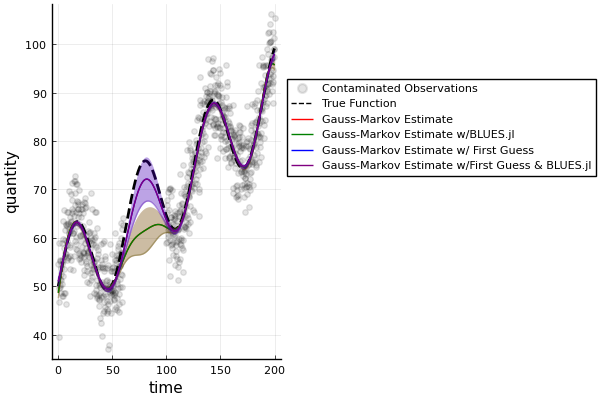

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [85]:
Lt = 25
σx = 20
yobs = vcat(xobs[2:300], xobs[500:end])
ygrid = vcat(xgrid[2:300], xgrid[500:end])

x0 = ones(nx) .* mean(yobs)

x̃, σx̃ = gauss_markov_mapping(yobs, ygrid, xgrid; Lt = Lt, σx = σx, σn = σn)
x̃_fg, σx̃_fg = gauss_markov_mapping(yobs, ygrid, xgrid; Lt = Lt, σx = σx, σn = σn, x0 = x0)
x̃b, σx̃b = gauss_markov_mapping_BLUES(yobs, ygrid, xgrid; Lt = Lt, σx = σx, σn = σn)
x̃bfg, σx̃bfg = gauss_markov_mapping_BLUES(yobs, ygrid, xgrid; Lt = Lt, σx = σx, σn = σn, x0 = x0)

#######PLOTTING########
scatter(ygrid, yobs, label = "Contaminated Observations", 
        alpha = 0.1, markercolor = "black", 
        xlabel = "time", ylabel = "quantity")
plot!(xgrid, myfunc.(xgrid), color = "black", label = "True Function", 
      alpha = 1, linestyle = :dash, lw = 2)

plot!(xgrid, x̃, color = "red", label = "Gauss-Markov Estimate")
plot_uncertainty!(xgrid, x̃, σx̃; color = "red", alpha = 0.3)

plot!(xgrid, x̃b, color = "green", label = "Gauss-Markov Estimate w/BLUES.jl")
plot_uncertainty!(xgrid, x̃b, σx̃b; color = "green", alpha = 0.3)

plot!(xgrid, x̃_fg, color = "blue", label = "Gauss-Markov Estimate w/ First Guess")
plot_uncertainty!(xgrid, x̃_fg, σx̃_fg; color = "blue", alpha = 0.3)

plot!(xgrid, x̃bfg, color = "purple", label = "Gauss-Markov Estimate w/First Guess & BLUES.jl")
plot_uncertainty!(xgrid, x̃bfg, σx̃bfg; color = "purple", alpha = 0.3)
plot!(legend=(1,0.5))
